In [2]:
import os, sys
sys.path.append('/home/oleg/Prog/Science/ship_tracks_recognition/functions')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from math import *
from Y_views import *
from UV_views import *
%matplotlib inline

In [4]:
all_mctracks = pd.read_csv('Data/MCTrack.csv', delimiter=',')
all_velo_points = pd.read_csv('Data/vetoPoint.csv', delimiter=',')
all_hits = pd.read_csv('Data/strawtubesPoint_decoded_hits.csv', delimiter=',')
all_hits['Index'] = all_hits.index

# Creating Learning Table

In [98]:
from ReconstructibleTracks import get_reconstractible_tracks

reconstructible_events = {}

for event_id in range(0, 2500):
    
    tracks = get_reconstractible_tracks(event_id, all_hits, all_mctracks, all_velo_points)
    
    if tracks != []:
        reconstructible_events[event_id] = tracks

In [99]:
match_table = {}
for i in all_hits.Index:
        match_table[all_hits.Index[i]] = all_hits.TrackID[i]

In [100]:
table = pd.DataFrame(columns=('N', 'Max', 'Min', 'deviation', 'Class'))
marks = {}

In [101]:
def dist2Track(point, track):
    return np.abs(- track[0] * point[0] + point[1] - track[1]) / np.sqrt(track[0]**2 + 1.0)

In [154]:
index = 1
for i in reconstructible_events:
    event = modify_for_yz_analysis_1_2(all_hits[all_hits['event'] == i])
    tracks_yz_1_2, linking_table_yz_1_2 = loop_yz(event, 7, 0.85, 0)
    for k in tracks_yz_1_2:
        N = len(linking_table_yz_1_2[k])
        dists = [dist2Track((event.Wz[j], event.Wy[j]), tracks_yz_1_2[k]) / event.dist2Wire[j] for j in linking_table_yz_1_2[k]]
        arr = [match_table[j] for j in linking_table_yz_1_2[k]]
        Max = np.max(dists)
        Min = np.min(dists)
        deviation = np.average(dists)
        _, counts = np.unique(arr, return_counts = True)
        cl = np.max(counts) / len(linking_table_yz_1_2[k])
        table.loc[index] = [N, Max, Min, deviation, cl]
        index += 1
    event = modify_for_yz_analysis_3_4(all_hits[all_hits['event'] == i])
    tracks_yz_3_4, linking_table_yz_3_4 = loop_yz(event, 7, 0.85, 1)
    for k in tracks_yz_3_4:
        N = len(linking_table_yz_3_4[k])
        dists = [dist2Track((event.Wz[j], event.Wy[j]), tracks_yz_3_4[k]) / event.dist2Wire[j] for j in linking_table_yz_3_4[k]]
        arr = [match_table[j] for j in linking_table_yz_3_4[k]]
        Max = np.max(dists)
        Min = np.min(dists)
        deviation = np.average(dists)
        _, counts = np.unique(arr, return_counts = True)
        cl = np.max(counts) / len(linking_table_yz_3_4[k])
        table.loc[index] = [N, Max, Min, deviation, cl]
        index += 1

In [155]:
table.head()

,N,Max,Min,deviation,Class
1,8,1.215309,0.759074,1.007472,1
2,8,1.039541,0.965492,1.000407,1
3,9,1.206719,0.026863,0.907816,1
4,8,1.143564,0.227930,0.833862,1
5,9,1.034219,0.279639,0.898669,1


In [156]:
table.to_csv('./Data/TracksTable.csv')

# Show efficiency of classifier

In [222]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

In [223]:
weight = {}
weight[0] = 1223
weight[1] = 32

In [224]:
clf = RandomForestClassifier(n_estimators=100, class_weight = weight)

In [225]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(table[['N', 'Max', 'Min', 'deviation']], table['Class'], test_size = 0.4)

In [226]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 1223, 1: 32},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [227]:
clf.score(X_test, y_test)

0.98207171314741037

# Decision Scores

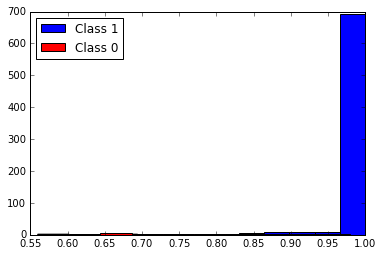

In [228]:
indexes_1 = [i for i in y_train.index if y_train[i] == 1]
indexes_0 = [i for i in y_train.index if y_train[i] == 0]
plt.hist(clf.predict_proba(X_train.T[indexes_1].T).T[1], color="blue", label="Class 1")
plt.hist(clf.predict_proba(X_train.T[indexes_0].T).T[0], color="red", label="Class 0")
plt.legend(loc="upper left")